# Custom Workloads with Dask Delayed
This is based on the Dask example from https://examples.dask.org/delayed.html but has been adapted to run on JASMIN.

Dask.delayed is a simple and powerful way to parallelize existing code. It allows users to delay function calls into a task graph with dependencies. Dask.delayed doesn’t provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed. If you have a problem that is paralellizable, but isn’t as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

In [1]:
%%time
import dask_gateway
import dask
# Create a connection to dask-gateway.
gw = dask_gateway.Gateway("https://dask-gateway.jasmin.ac.uk", auth="jupyterhub")

# Inspect and change the options if required before creating your cluster.
options = gw.cluster_options()
options.worker_cores = 1 #keeping this at 1 and allowing 15 worker processes seems to run faster than the other way around
options.scheduler_cores = 1 #we need at least one core for the scheduler
#specify which conda env to use, this must match the versions of python and dask (and a few other libraries) used on the notebook service
options.worker_setup='source /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/bin/activate /gws/smf/j04/canari/dask-env'

# Create a dask cluster, or, if one already exists, connect to it.
# This stage creates the scheduler job in SLURM, so may take some time.
# While your job queues.
clusters = gw.list_clusters()
if not clusters:
    cluster = gw.new_cluster(options, shutdown_on_close=False)
else:
    cluster = gw.connect(clusters[0].name)

# Create at least one worker, and allow your cluster to scale to 15.
# The max JASMIN allows is 16, but one of these is used as the scheduler.
cluster.adapt(minimum=1, maximum=15)

# Get a dask client.
client = cluster.get_client()

CPU times: user 1.44 s, sys: 868 ms, total: 2.31 s
Wall time: 20 s


The link to the dashboard will become visible below. We recommend having it open on one side of your screen while using your notebook on the other side. This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

On JASMIN the Dashboard can be shown by connecting a web browser to the address (something like https://dask-gateway.jasmin.ac.uk/clusters/3189803deca44f60bdc9653e06cc180d/status) returned by the cell below. But this is only available on the JASMIN network, so we have to do it over the [Jasmin No Machine login](https://help.jasmin.ac.uk/docs/interactive-computing/graphical-linux-desktop-access-using-nx/).


In [2]:
client

<Client: 'tls://172.17.11.136:45854' processes=0 threads=0, memory=0 B>

## Create simple functions

These functions do simple operations like add two numbers together, but they sleep for a random amount of time to simulate real work.

In [3]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

We can run them like normal Python functions below

In [4]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 2.15 ms, sys: 1.6 ms, total: 3.75 ms
Wall time: 2.2 s


3

These ran one after the other, in sequence. Note though that the first two lines inc(1) and dec(2) don’t depend on each other, we could have called them in parallel had we been clever.

## Annotate functions with Dask Delayed to make them lazy

We can call dask.delayed on our funtions to make them lazy. Rather than compute their results immediately, they record what we want to compute as a task into a graph that we’ll run later on parallel hardware.

In [5]:
inc_delayed = dask.delayed(inc)
dec_delayed = dask.delayed(dec)
add_delayed = dask.delayed(add)

Calling these lazy functions is now almost free. We’re just constructing a graph

In [6]:
x = inc_delayed(1)
y = dec_delayed(2)
z = add_delayed(x, y)
z

Delayed('add-a03fe6a5-ab63-4c49-82f3-3ceb71005fc6')

## Visualize computation

You will need graphviz installed for this to work

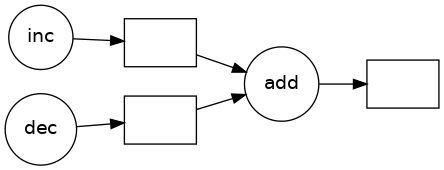

In [7]:
z.visualize(rankdir='LR')

## Run in parallel

Call .compute() when you want your result as a normal Python object

If you started Client() above then you may want to watch the status page during computation.

In [8]:
z.compute()

3

## Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code. This generates graphs instead of doing computations directly, but still looks like the code we had before. Dask is a convenient way to add parallelism to existing workflows.

In [9]:
zs = []

In [10]:
%%time
for i in range(256):
    x = inc_delayed(i)
    y = dec_delayed(x)
    z = add_delayed(x, y)
    zs.append(z)

CPU times: user 28.4 ms, sys: 13.6 ms, total: 42 ms
Wall time: 32.1 ms


In [11]:
%%time
zs = dask.persist(*zs) # trigger computation in the background

CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 20.3 ms


## Custom computation: Tree summation

As an example of a non-trivial algorithm, consider the classic tree reduction (to sum the value of zs in parallel). We accomplish this with a nested for loop and a bit of normal Python logic.

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

In [12]:
%%time
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add_delayed(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

CPU times: user 278 ms, sys: 27.7 ms, total: 306 ms
Wall time: 40.6 s


([65536],)

In [13]:
cluster.shutdown() #shutdown our dask cluster. If we want to use it for something else we could remove this, but starting a new one only takes a few seconds

In [14]:
#%%time
#serialised version for comparison. uncomment if you want to try it

#zs = []
#for i in range(256):
#    x = inc(i)
#    y = dec(x)
#    z = add(x, y)
#    zs.append(z)

#L = zs
#while len(L) > 1:
#    new_L = []
#    for i in range(0, len(L), 2):
#        lazy = add(L[i], L[i + 1])  # add neighbors
#        new_L.append(lazy)
#    L = new_L                       # swap old list for new
#L
